### Investigating  Data
Use the apple mobility data set attached as a zipped csv. Read in the raw data, and filter to any two countries. Resample to weekly data and find if they are correlated

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.stats import linregress, pearsonr

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
# read df
df = pd.read_csv("data\\apple_mobility_data.zip", low_memory=False)

# important columns for country data
dim_cols = ['region', 'transportation_type']
date_cols = list(df.columns[6:].values)
transportation_types = df['transportation_type'].unique()

# restrict to countries
country_df = df[df['geo_type'] == 'country/region']
country_df = country_df[dim_cols + date_cols].copy()
country_df.head()

,region,transportation_type,2020-01-13,2020-01-14,2020-01-15,2020-01-16,2020-01-17,2020-01-18,2020-01-19,2020-01-20,...,2022-02-15,2022-02-16,2022-02-17,2022-02-18,2022-02-19,2022-02-20,2022-02-21,2022-02-22,2022-02-23,2022-02-24
0,Albania,driving,100.0,95.30,101.43,97.20,103.55,112.67,104.83,94.39,...,156.04,159.59,158.80,173.06,196.42,179.48,163.30,155.11,155.52,165.68
1,Albania,walking,100.0,100.68,98.93,98.46,100.85,100.13,82.13,95.65,...,185.16,171.73,198.46,216.12,210.41,159.66,201.41,188.36,205.25,208.44
2,Argentina,driving,100.0,97.07,102.45,111.21,118.45,124.01,95.44,95.13,...,114.10,116.78,119.40,142.49,148.51,99.60,108.15,110.96,116.21,119.52
3,Argentina,walking,100.0,95.11,101.37,112.67,116.72,114.14,84.54,101.37,...,119.62,126.77,133.51,151.40,132.82,83.20,121.40,128.47,133.02,123.65
4,Australia,driving,100.0,102.98,104.21,108.63,109.08,89.00,99.35,103.53,...,131.07,134.70,146.48,145.41,121.64,129.18,130.65,132.81,133.67,145.25


In [4]:
def prep_by_country(df, countries):
    """Filter to given countries and
    prepare date columns to rows."""
    df = df[df['region'].isin(countries)]
    df = df.melt(id_vars=['region', 'transportation_type'], var_name='Date', value_name='mobility')
    df['Date'] = df['Date'].apply(pd.to_datetime)
    
    return df

def resample_weekly(df, cols):
    """Resample weekly by given cols"""
    df = df.set_index('Date')
    return df.groupby(cols).resample('W').mean().reset_index()

nordan_df = prep_by_country(country_df, ['Denmark', 'Norway'])
weekly_df = resample_weekly(nordan_df, ['region'])
weekly_df.head()

,region,Date,mobility
0,Denmark,2020-01-19,105.547619
1,Denmark,2020-01-26,106.663810
2,Denmark,2020-02-02,113.200952
3,Denmark,2020-02-09,107.650952
4,Denmark,2020-02-16,108.421905


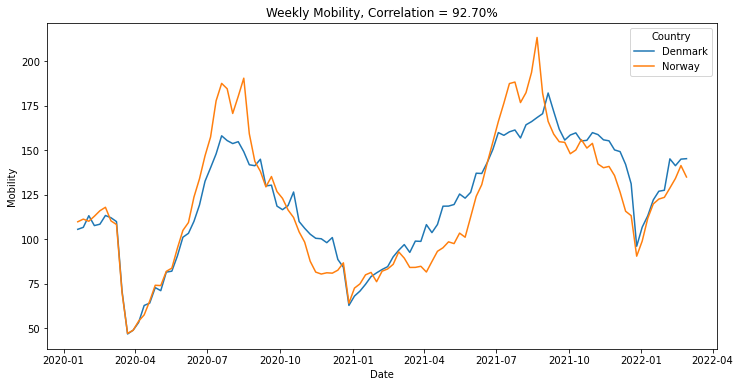

Correlation: 0.93, p-value: 0.000000


In [5]:
def plot_series(df, countryA, countryB):
    """Plot the two series"""
    pivot_df = df.pivot(index='Date', columns='region', values='mobility')
    correlation, p_value = pearsonr(pivot_df[countryA], pivot_df[countryB])

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df, x='Date', y='mobility', hue='region')
   
    plt.title(f'Weekly Mobility, Correlation = {correlation * 100:.2f}%')
    plt.xlabel('Date')
    plt.ylabel('Mobility')
    plt.legend(title='Country')
    plt.show()

    print(f"Correlation: {correlation:.2f}, p-value: {p_value:.6f}")

plot_series(weekly_df, 'Denmark', 'Norway')

#### Mobility trends between Denmark and Norway have a strong positive linear relationship. This suggests that when mobility increases or decreases in one country, it tends to change similarly in the other country too.
Some possible reasons:
1. Similar lockdown strategies and social distancing rules by governments and health organizations
2. Geographical proximity between Denmark and Norway
2. Similarity in climate: Warmer temperatures during summer results in higher mobility compared to cold periods
3. Interconnected economic and social structures between the two countries

##### Very low p-value suggests that the correlation coefficient is statistically significant. Thus, null hypothesis that there is no correlation is not supported.

slope: 1.09, R squared: 0.93, p-value: 0.000000, coefficient std error: 0.04


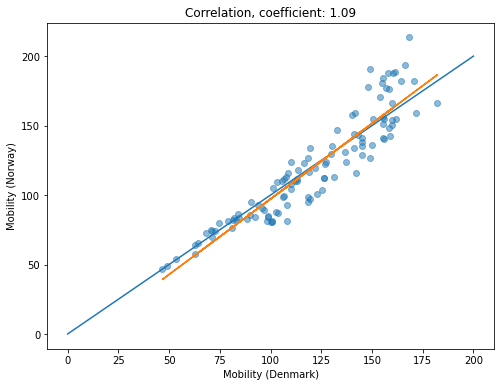

In [6]:
def plot_corr(df, countryA, countryB, pivot='region'):
    """Plot correlation"""
    pivot_df = df.pivot(index='Date', columns=pivot, values='mobility')
    plt.figure(figsize=(8, 6))
    plt.scatter(pivot_df[countryA], pivot_df[countryB], alpha=0.5)
    
    # y = x
    plt.plot([0, 200], [0, 200])
    
    # fit
    m, c, r_squared, p_value, std_err = linregress(pivot_df[countryA], pivot_df[countryB])
    print(f'slope: {m:.2f}, R squared: {r_squared:.2f}, p-value: {p_value:.6f}, coefficient std error: {std_err:.2f}')
    fit = m * pivot_df[countryA] + c
    plt.plot(pivot_df[countryA], fit)

    plt.title(f'Correlation, coefficient: {m:.2f}')
    plt.xlabel(f'Mobility ({countryA})')
    plt.ylabel(f'Mobility ({countryB})')
    plt.show()

plot_corr(weekly_df, 'Denmark', 'Norway')

#### As most points are below linear line, it suggests that Denmark has slightly higher mobility values compared to Norway, even though they are highly correlated.
Denmark's population is slightly higher than Norway, has slightly longer summer periods, and warmer temperature.
##### Regression coefficient is slightly higher that linear. This suggests mobiity in Norway changes slightly more for one unit change in mobility in Denmark.
The peaks for Norway are higher than in Denmark.
We should analyze mobility trends by transportation type and location-wise to better explain this.

### Break up by transportation type

driving: Correlation: 0.89, p-value: 0.000000
walking: Correlation: 0.93, p-value: 0.000000
transit: Correlation: 0.95, p-value: 0.000000


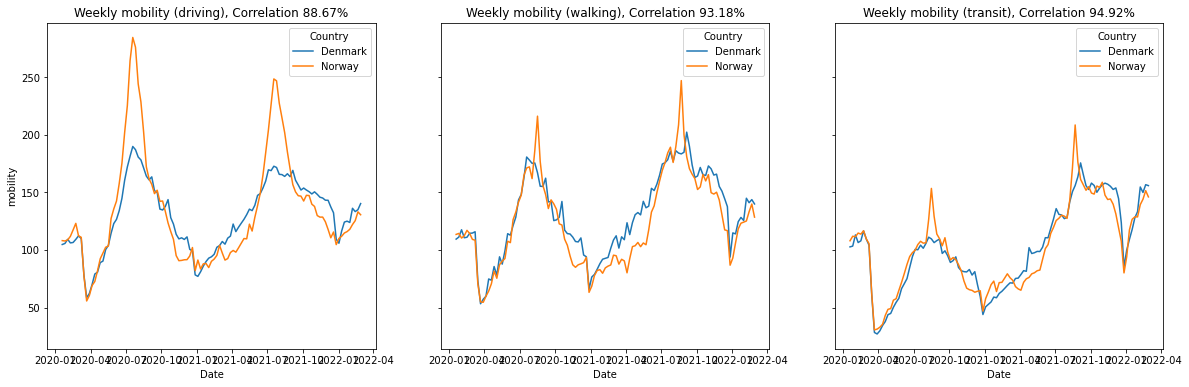

In [7]:
def plot_series_by_types(df, transportation_types, countryA, countryB):
    """Plot the two series broken
    down by the transit types."""
    fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    for ax, trans_type in zip(axs, transportation_types):
        trans_df = df[df['transportation_type'] == trans_type]
        pivot_df = trans_df.pivot(index='Date', columns='region', values='mobility')

        correlation, p_value = pearsonr(pivot_df[countryA], pivot_df[countryB])

        sns.lineplot(data=trans_df, x='Date', y='mobility', hue='region', ax=ax)
        ax.set_title(f'Weekly mobility ({trans_type}), Correlation {correlation * 100:.2f}%')
        ax.set_xlabel('Date')
        ax.set_ylabel('mobility')
        ax.legend(title='Country')
        print(f'{trans_type}: Correlation: {correlation:.2f}, p-value: {p_value:.6f}')

    plt.show()

weekly_trans_df = resample_weekly(nordan_df, ['region', 'transportation_type'])
plot_series_by_types(weekly_trans_df, transportation_types, 'Denmark', 'Norway')

#### Mobility trends by transportation type between Denmark and Norway also have a strong positive linear relationship. 
##### The mobility trends of each type and (overall) follow the solstice calendar. There is increase in mobility during the summer time with warmer temperatures and longer days. Conversely, decrease in mobility during the winter months. 
It's possible that lockdown restrictions were lifted over the summer of 2020 and then again in 2021.
The winter of late 2020 and early 2021 saw second wave of COVID, hence it's possible some of the restrictions were reimposed in both countries.
##### Public transit has higher correlation compared to driving, perhaps due to the fact that governments could control public transit better and both governments had similar lockdown strategies.

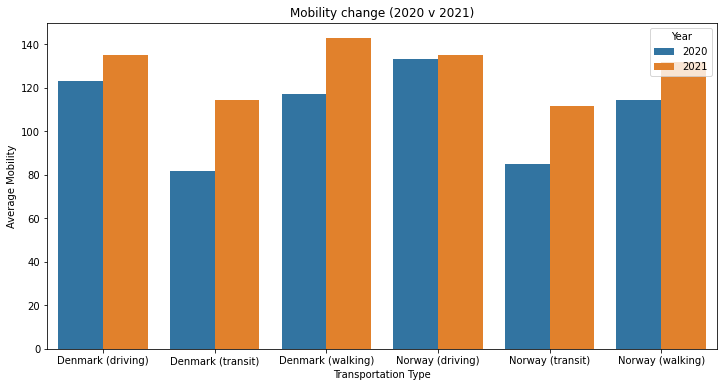

In [8]:
def plot_avg_mobility_by_year(df):
    df['year'] = df['Date'].dt.year
    mobility_df = df[df['year'].isin([2020, 2021])].copy()

    # Group by year, region, and transportation type, and calculate the average mobility
    avg = mobility_df.groupby(['year', 'region', 'transportation_type']).agg({'mobility': 'mean'}).reset_index()
    avg['region_trans'] = avg['region'] + ' (' + avg['transportation_type'] + ')'

    plt.figure(figsize=(12, 6))
    sns.barplot(data=avg, x='region_trans', y='mobility', hue='year')

    plt.title('Mobility change (2020 v 2021)')
    plt.xlabel('Transportation Type')
    plt.ylabel('Average Mobility')
    plt.legend(title='Year')
    plt.show()

plot_avg_mobility_by_year(weekly_trans_df)

##### Between 2020 and 2021, overall mobility has increased. An interesting observation is that walking and transit have seen a larger corresponding increase compared to driving. This suggests that people shifted more towards public transport vis-a-vis private vehicles as lockdowns were relaxed.

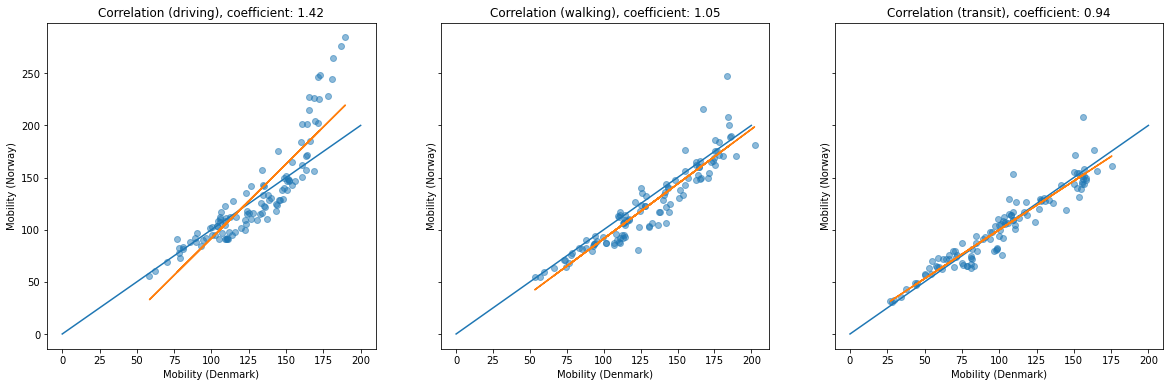

In [9]:
def plot_corr_by_types(df, transportation_types, countryA, countryB):
    """Plot correlation by transportation type"""
    fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

    for ax, trans_type in zip(axs, transportation_types):
        trans_df = df[df['transportation_type'] == trans_type]
        pivot_df = trans_df.pivot(index='Date', columns='region', values='mobility')
        ax.scatter(pivot_df[countryA], pivot_df[countryB], alpha=0.5)
        ax.plot([0, 200], [0, 200])

        # fit
        m, c = np.polyfit(pivot_df[countryA], pivot_df[countryB], 1)
        fit = m * pivot_df[countryA] + c
        ax.plot(pivot_df[countryA], fit)

        ax.set_title(f'Correlation ({trans_type}), coefficient: {m:.2f}')
        ax.set_xlabel(f'Mobility ({countryA})')
        ax.set_ylabel(f'Mobility ({countryB})')

    plt.show()

plot_corr_by_types(weekly_trans_df, transportation_types, 'Denmark', 'Norway')

#### Norway driving mobility increases at much higher pace than Denmark, expecially during the peak season. This is interesting from the perspective of Vitol in terms of fuel and power consumption for private vehicles. Need further data to explain this.

Weekly change (driving): Correlation: 0.65, p-value: 0.000000
Weekly change (walking): Correlation: 0.50, p-value: 0.000000
Weekly change (transit): Correlation: 0.62, p-value: 0.000000


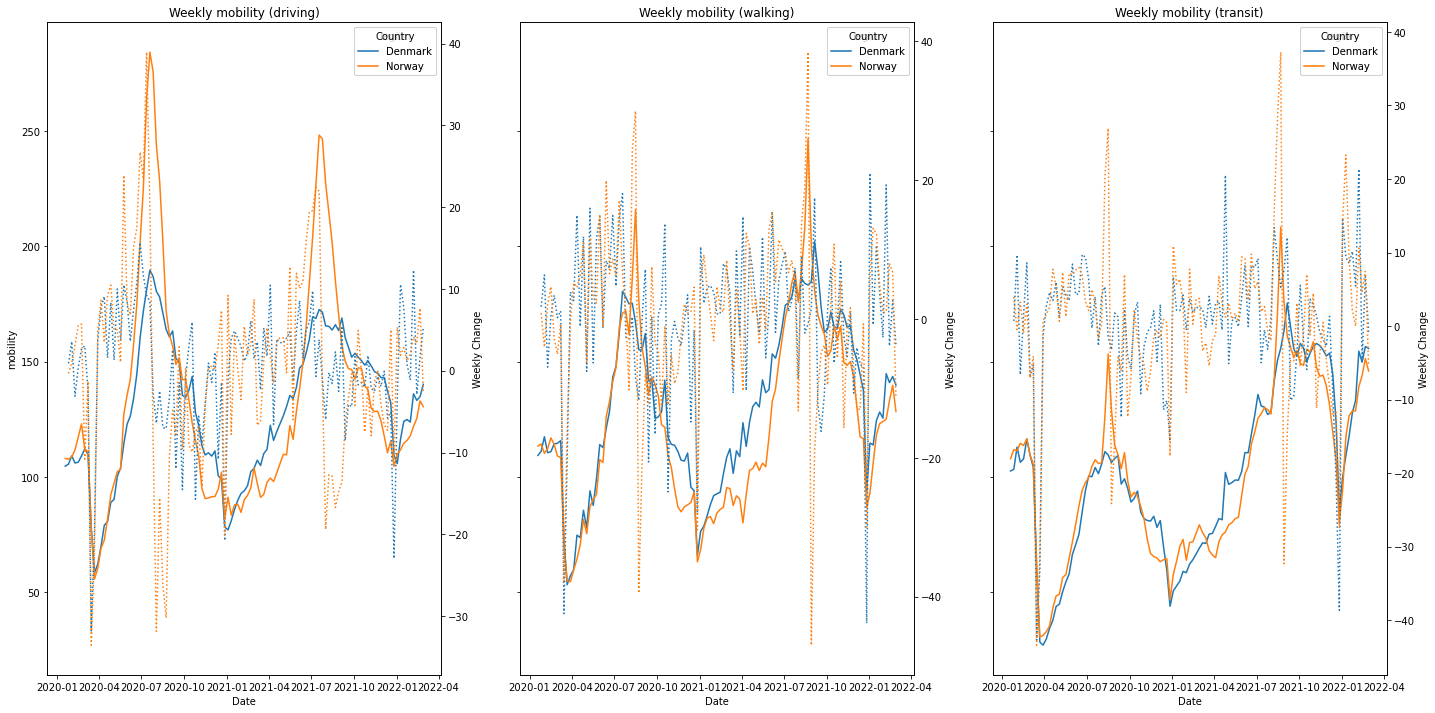

In [10]:
def plot_series_by_types_weekly_change(df, transportation_types, countryA, countryB):
    fig, axs = plt.subplots(1, 3, figsize=(24, 12), sharey=True)

    for ax, trans_type in zip(axs, transportation_types):
        trans_df = df[df['transportation_type'] == trans_type].copy()

        sns.lineplot(data=trans_df, x='Date', y='mobility', hue='region', ax=ax)
        ax.set_title(f'Weekly mobility ({trans_type})')
        ax.set_xlabel('Date')
        ax.set_ylabel('mobility')

        # week-on-week changes
        ax2 = ax.twinx()
        trans_df['weekly_change'] = trans_df.groupby('region')['mobility'].diff()
        sns.lineplot(data=trans_df, x='Date', y='weekly_change', hue='region', ax=ax2, linestyle=':')
        ax2.set_ylabel('Weekly Change')
        ax2.legend(title='Country')

        pivot_df = trans_df.pivot(index='Date', columns='region', values='weekly_change').dropna()
        correlation, p_value = pearsonr(pivot_df[countryA], pivot_df[countryB])
        print(f'Weekly change ({trans_type}): Correlation: {correlation:.2f}, p-value: {p_value:.6f}')

    plt.show()

plot_series_by_types_weekly_change(weekly_trans_df, transportation_types, 'Denmark', 'Norway')

#### Week-on-week changes in mobility is still highly correlated between Denmark and Norway. 
Driving and transit show a stronger correlation, suggesting similar factors influence both such as lockdown strategy, social distancing rules, and availability.
##### This seems to support the idea that both Denmark and Norway are similar countries and had similar response to COVID in terms of lockdown strategies and social distancing rules by governments and public health organizations.

### Same analysis for two vastly different countries

In [11]:
italus_df = prep_by_country(country_df, ['Italy', 'United States'])
weekly_italus_df = resample_weekly(italus_df, ['region'])
weekly_italus_df.head()

,region,Date,mobility
0,Italy,2020-01-19,108.835238
1,Italy,2020-01-26,110.424762
2,Italy,2020-02-02,109.865238
3,Italy,2020-02-09,112.879524
4,Italy,2020-02-16,127.586190


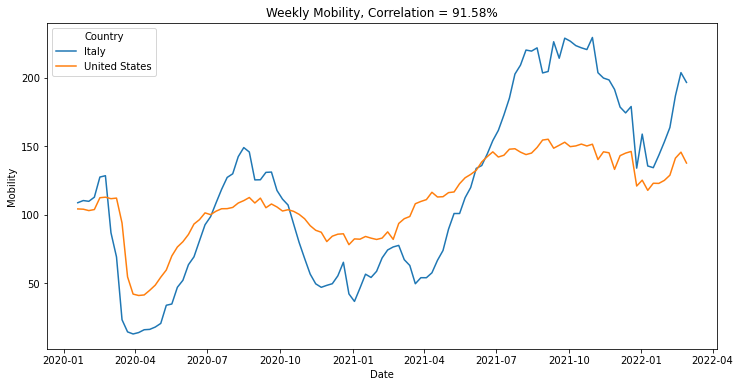

Correlation: 0.92, p-value: 0.000000
slope: 0.42, R squared: 0.92, p-value: 0.000000, coefficient std error: 0.02


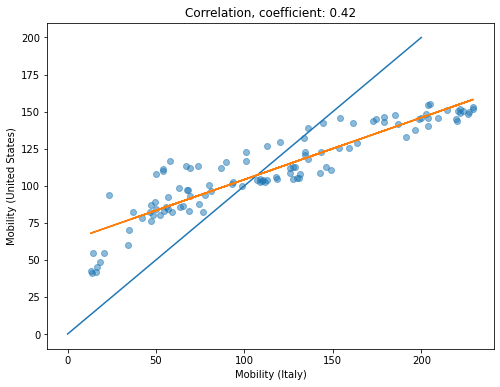

In [12]:
plot_series(weekly_italus_df, 'Italy', 'United States')
plot_corr(weekly_italus_df, 'Italy', 'United States')

#### Mobility trends between Italy and United States have a strong positive linear relationship. This suggests that when mobility increases or decreases in one country, it tends to change in the other country in the same direction.
##### A low regression coefficient suggests mobility in Italy experiences large changes as compared to United States.

In [13]:
def compare_variability(df, countries):
    for country in countries:
        mobility = df[df['region'] == country]['mobility']
        std_dev = mobility.std()
        variance = mobility.var()
        print(f'{country}: std dev: {std_dev:.2f}, variance: {variance:.2f}')

compare_variability(weekly_italus_df, ['Italy', 'United States'])

Italy: std dev: 63.46, variance: 4027.39
United States: std dev: 28.92, variance: 836.27


##### Italy has much higher variance as compared to United States.
Some possible reasons:
1. Higher population density
2. Stricter lockdown strategy in Italy as compared to United States 
3. Subsequent relaxation resulting in pent-up mobility

driving: Correlation: 0.85, p-value: 0.000000
walking: Correlation: 0.86, p-value: 0.000000
transit: Correlation: 0.90, p-value: 0.000000


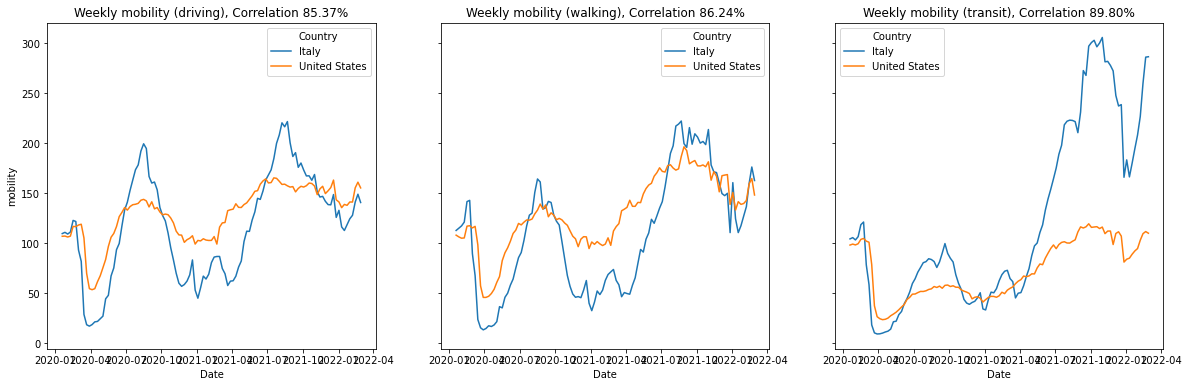

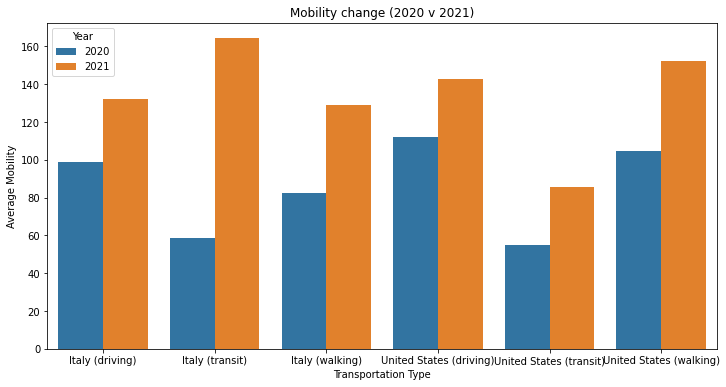

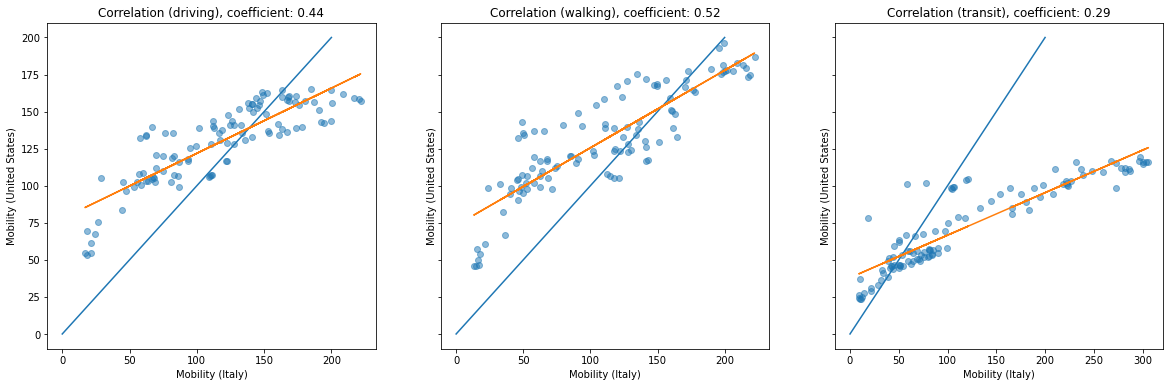

In [14]:
weekly_italus_trans_df = resample_weekly(italus_df, ['region', 'transportation_type'])
plot_series_by_types(weekly_italus_trans_df, transportation_types, 'Italy', 'United States')
plot_avg_mobility_by_year(weekly_italus_trans_df)
plot_corr_by_types(weekly_italus_trans_df, transportation_types, 'Italy', 'United States')

#### Mobility trends by transportation type between Italy and United States also have strong positive linear relationship.
##### However, there are several notable differences
1. The mobility trends of each type and (overall) is more sensitive to solstice calendar in Italy as compared to United States. We can explore sub-region data to check if the vast geographical expanse of United States may be responsible for this. 
2. All three mobility types are more sensitive in Italy as compared to United States, in line with overall mobility trends.
3. Transit mobility is especially sensitive in Italy compared to United States.

##### What could be the reasons for it?

slope: 0.70, R squared: 0.75, p-value: 0.000000, coefficient std error: 0.06


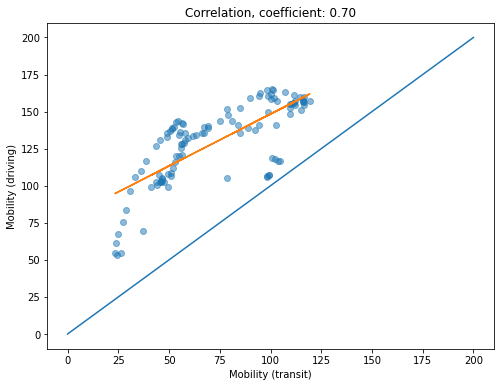

In [15]:
weekly_us_trans_df = weekly_italus_trans_df[weekly_italus_trans_df['region'] == 'United States']
plot_corr(weekly_us_trans_df, 'transit', 'driving', 'transportation_type')

##### United States public transit is under-developed, but this can't seem to explain as US mobility trends in driving and public transit follow similar trend (driving is obviously more preferred)

driving: Correlation: 0.78, p-value: 0.000000
walking: Correlation: 0.86, p-value: 0.000000
transit: Correlation: 0.86, p-value: 0.000000


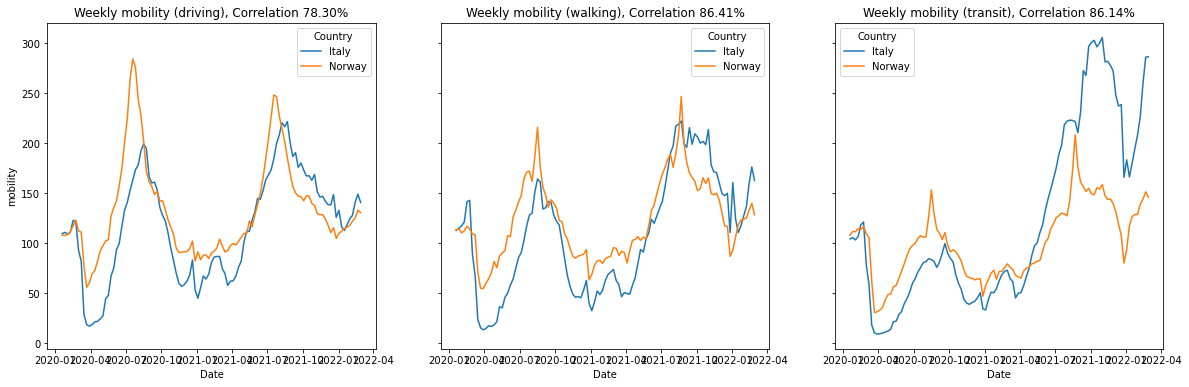

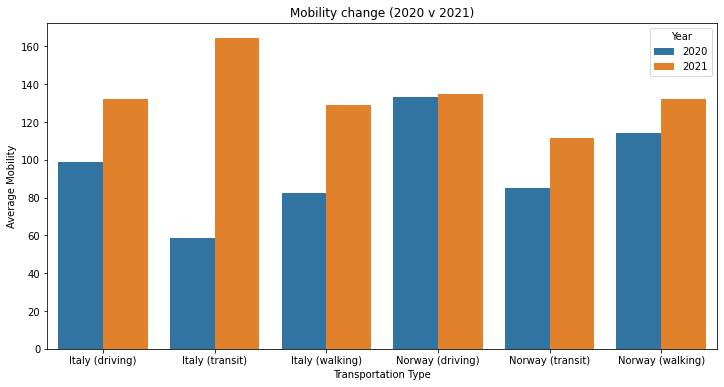

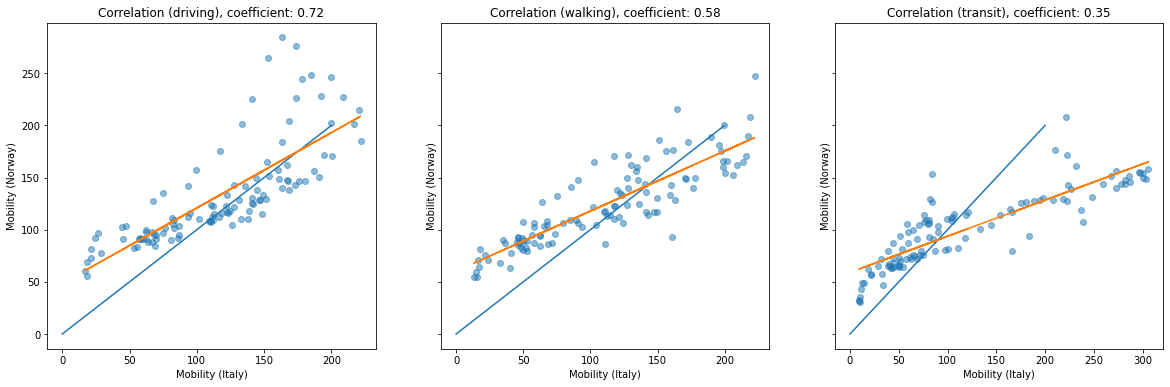

In [16]:
itanor_df = prep_by_country(country_df, ['Italy', 'Norway'])
weekly_italus_df = resample_weekly(itanor_df, ['region'])
weekly_italnor_trans_df = resample_weekly(itanor_df, ['region', 'transportation_type'])

plot_series_by_types(weekly_italnor_trans_df, transportation_types, 'Italy', 'Norway')
plot_avg_mobility_by_year(weekly_italnor_trans_df)
plot_corr_by_types(weekly_italnor_trans_df, transportation_types, 'Italy', 'Norway')

#### Italy is more correlated to Norway than to United States.
This is understandable because of geographical proximity and more interconnected economic and social structures between the two countries.
##### Increase in Italy's transit mobility in 2021 compared to 2020 is still largely unexplained. Need further data to explain this.

Weekly change (driving): Correlation: 0.45, p-value: 0.000001
Weekly change (walking): Correlation: 0.43, p-value: 0.000002
Weekly change (transit): Correlation: 0.48, p-value: 0.000000


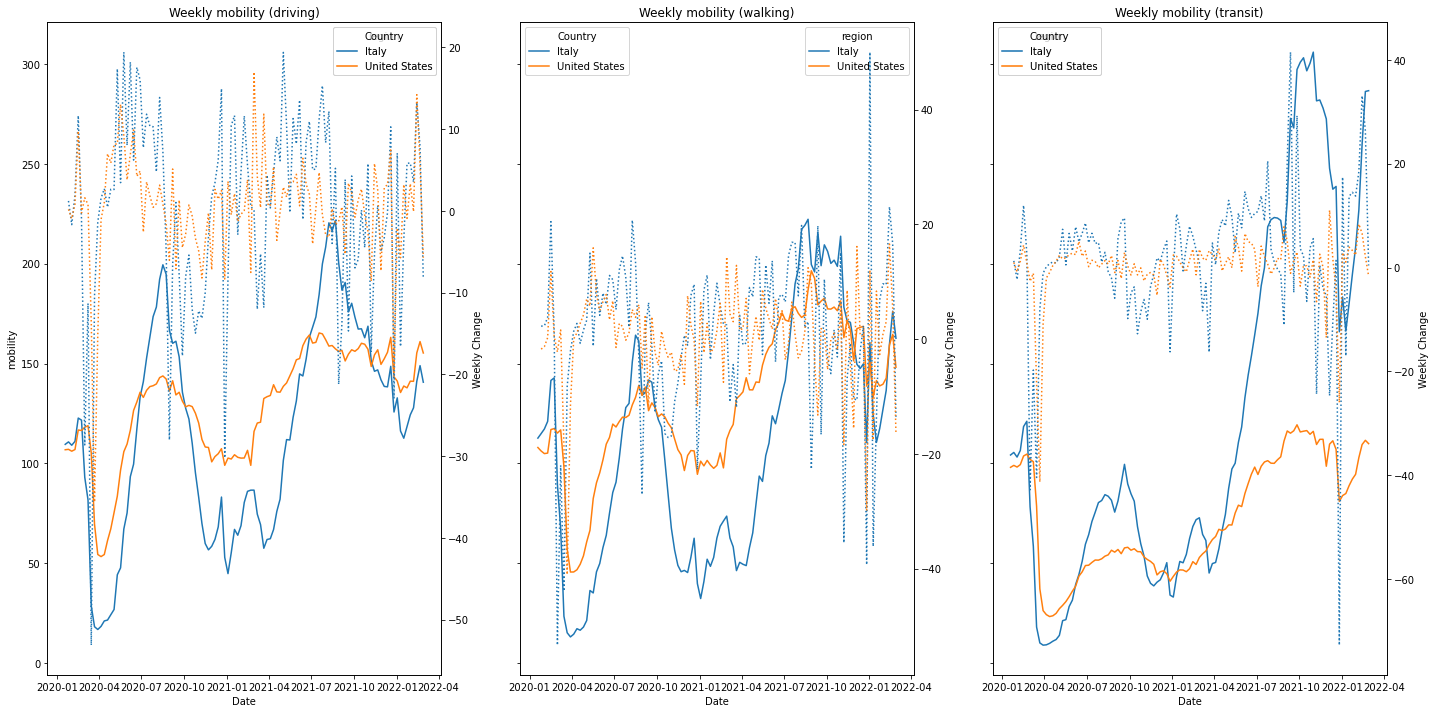

In [17]:
plot_series_by_types_weekly_change(weekly_italus_trans_df, transportation_types, 'Italy', 'United States')

#### Week-on-week changes in mobility is still quite correlated between Italy and United States.
#### More observations
1. Mobility trend is flatter in United States. This suggests less variability in lockdown strategy over the COVID period as compared to Italy.
2. Transit mobility has barely picked up in United States to pre-COVID levels, whereas Italy's transit mobility has sky-rocketed post COVID.

### Comparison between Denmark-Norway and Italy-United States
##### Observations
1. Correlation between Denmark and Norway is only slightly higher compared to between Italy and United States
2. However, sensitivity of mobility of changes in Denmark and Norway is very similar but the corresponding sensitivity between Italy and United States is not similar. Italy is much more sensitive to changes than one unit change in United States.

##### Some possible reasons
1. <i>Geographical differences</i>: Denmark and Norway are neighbours whereas Italy and United States are in different continents. Unites States is vast with diverse geography, which can result in less similarities between the two countries.
2. <i>Population</i>: Denmark and Norway have similar population density whereas Italy and United States have much different population and different population density across the country.
3. <i>Lockdown Strategy</i>: Denmark and Norway had similar lockdown strategy whereas United States had much looser lockdown compared to Italy. Thus it observed flatter mobility.
4. <i>External mobility</i>: People move more frquently between Norway and Denmark and also from Europe. Same with Italy. However, United States saw fall in immigration during the COVID period which could result in lower variability in mobility.

There could be further reasons for the difference for which further research is required e.g. what caused spike in transit in Italy after 2021 and analysis of United States' geographical diversity with mobility. 

### Modelling with Data
Model US weekly mobility data for future predictions

In [18]:
# US country overall
us_df = prep_by_country(country_df, ['United States'])
weekly_us_df = resample_weekly(us_df, ['region'])
weekly_us_trans_df = resample_weekly(us_df, ['region', 'transportation_type'])

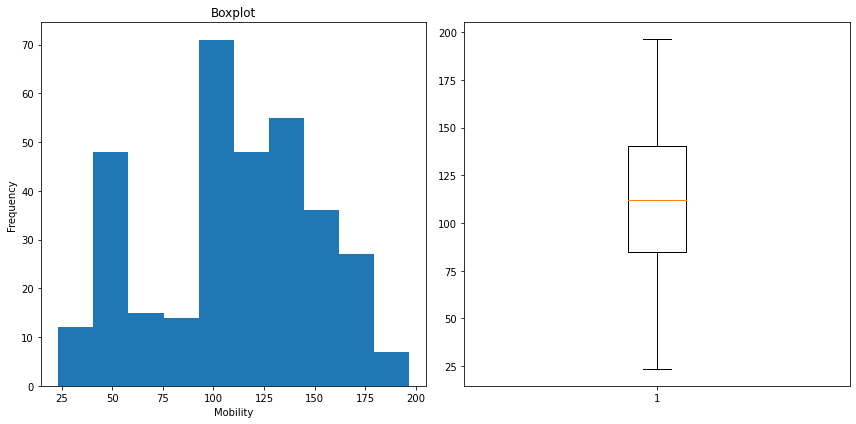

,mobility
count,333.000000
mean,110.793463
std,40.720642
min,23.368571
25%,84.952857
50%,112.108571
75%,140.567143
max,196.460000


In [19]:
def plot_hist_box(df, column):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.hist(df[column])
    ax1.set_title('Histogram')
    ax1.set_xlabel('Mobility')
    ax1.set_ylabel('Frequency')

    ax2.boxplot(df[column])
    ax1.set_title('Boxplot')
    ax1.set_xlabel('Mobility')

    plt.tight_layout()
    plt.show()

plot_hist_box(weekly_us_trans_df, 'mobility')

# Null check
weekly_us_df.isna().sum(), weekly_us_trans_df.isna().sum()

weekly_us_trans_df.describe()

#### Anomaly?
we see a larger number of days with mobility between 40 and 60. This corresponds to the first lockdown which was stricter than subsequent ones and was better observed by residents. <i>Should we remove these?</i> Otherwise, mobility seems reasonably normaly-distributed. <i>Perform additional checks</i>
#### Choices
1. <i>Null check</i>: No null values. Good
2. <i>Extra features</i>: There seems seasonality from previous analysis. Hence add extra temporal features for weekday, month, and year.
Average driving mobility may depend on other mobility as there could be transfer between different transportation_types.
Also, add overall mobility as another feature as it may help in capturing more correlation.
3. <i>One-hot encoding</i>: Convert the categorical feature transportation_type to numeric. However, we are considering transportation_type as a feature so we don't require this.
4. <i>Normalization</i>: We can normalize mobility and temporal features. Both are positive entities - we can use MinMaxScaler.

#### Granularity
We have considered only country level data. United States is a very diverse country in terms of local government policies, climate, population density, and guideline following. Hence, county or city/sub-region level data could provide more granular insights in mobility trends. Need further data to aggregate granular data to national average data for the modelling problem.

In [20]:
# transpose transportation_type to features
weekly_us_trans_processed = weekly_us_trans_df.pivot_table(index=['region', 'Date'], columns='transportation_type', values='mobility').reset_index()

# one-hot encoding for transportation type
# weekly_us_trans_processed = pd.get_dummies(weekly_us_trans_processed, columns=['transportation_type'])

# Add overall mobility
weekly_us_processed = pd.merge(weekly_us_trans_processed, weekly_us_df, on=['region', 'Date'], how='left')
weekly_us_processed.columns = ['region', 'Date', 'driving', 'transit', 'walking', 'overall']

def add_weekday_month(df, dt_col='Date'):
    """Add weekday and month"""
    df['weekday'] = df[dt_col].dt.weekday
    df['month'] = df[dt_col].dt.month
    df['year'] = df[dt_col].dt.year - min(df[dt_col].dt.year)
    return df

weekly_us_processed = add_weekday_month(weekly_us_processed)

def normalize(df, cols):
    """normalize numeric columns"""
    df[cols] = MinMaxScaler().fit_transform(df[cols])
    return df

weekly_us_processed = normalize(weekly_us_processed, ['driving', 'walking', 'transit', 'overall', 'weekday', 'month', 'year'])
weekly_us_processed.head()

,region,Date,driving,transit,walking,overall,weekday,month,year
0,United States,2020-01-19,0.477773,0.778244,0.413312,0.553966,0.0,0.000000,0.0
1,United States,2020-01-26,0.479546,0.788379,0.401735,0.552287,0.0,0.000000,0.0
2,United States,2020-02-02,0.471227,0.779688,0.393087,0.543315,0.0,0.090909,0.0
3,United States,2020-02-09,0.478742,0.792249,0.394801,0.550053,0.0,0.090909,0.0
4,United States,2020-02-16,0.565993,0.837270,0.472935,0.625672,0.0,0.090909,0.0


### Build model and test accuracy

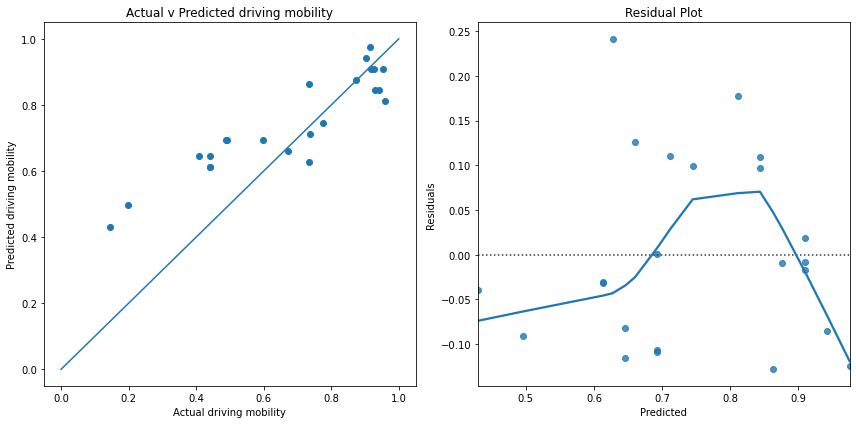

Baseline Linear Regression: MSE: 0.0217, RMSE: 0.1472, R-squared: 0.6455


In [21]:
def split_data(df, features, prediction):
    X = df[features]
    y = df[prediction]
    return train_test_split(X, y, test_size=0.2, random_state=1729 * 42)
    
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    return model

def plot_model(y_test, y_pred, prediction):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.scatter(y_test, y_pred)
    ax1.plot([0, 1], [0, 1])
    ax1.set_xlabel(f'Actual {prediction} mobility')
    ax1.set_ylabel(f'Predicted {prediction} mobility')
    ax1.set_title(f'Actual v Predicted {prediction} mobility')

    # Residual plot
    sns.residplot(x=y_pred, y=y_test - y_pred, lowess=True, ax=ax2)
    ax2.set_xlabel('Predicted')
    ax2.set_ylabel('Residuals')
    ax2.set_title('Residual Plot')

    plt.tight_layout()
    plt.show()
    
def evaluate_model(model, X_test, y_test, prediction):
    y_pred = model.predict(X_test)
    plot_model(y_test, y_pred, prediction)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return mse, rmse, r2, y_pred

def pipeline(model, df, features, prediction):
    X_train, X_test, y_train, y_test = split_data(df, features, prediction)
    model = train_model(model, X_train, y_train)
    return model, evaluate_model(model, X_test, y_test, prediction)

_model, (mse, rmse, r2, _) = pipeline(LinearRegression(), weekly_us_processed, ['weekday', 'month', 'year'], 'driving')
print(f'Baseline Linear Regression: MSE: {mse:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}')

#### Baseline - Linear Regression
No lag. Remove highly dependent feature columns.
##### Medium MSE and RMSE. Able to explain majority variance
However we can improve further with lag.

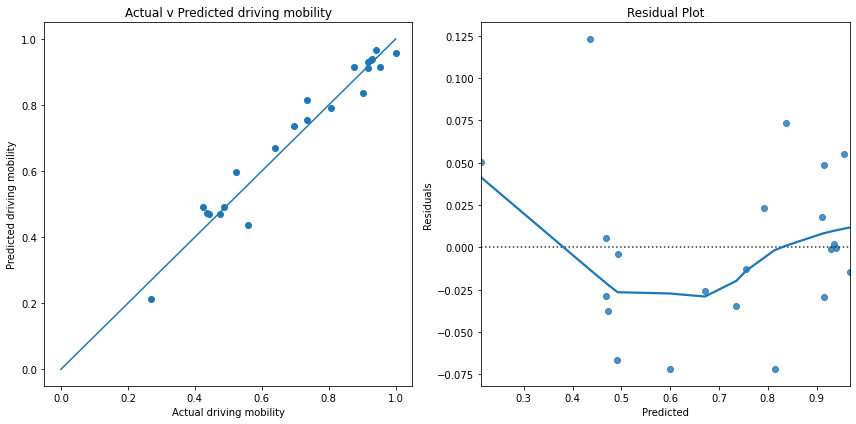

Lag Linear Regression: MSE: 0.0023, RMSE: 0.0480, R-squared: 0.9513


In [22]:
lag1 = weekly_us_processed.copy()
lag1['driving_lag1'] = lag1['driving'].shift(1)
lag1['transit_lag1'] = lag1['transit'].shift(1)
lag1['walking_lag1'] = lag1['walking'].shift(1)
lag1['overall_lag1'] = lag1['overall'].shift(1)

lag1 = lag1.dropna()
lag1_model, (mse, rmse, r2, _) = pipeline(LinearRegression(), lag1, ['weekday', 'month', 'year', 'driving_lag1', 'transit_lag1', 'walking_lag1', 'overall_lag1'], 'driving')
print(f'Lag Linear Regression: MSE: {mse:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}')

#### One week Lag - Linear Regression
One week lag. Use all lag columns and temporal columns 
##### Tiny MSE and RMSE. And able to explain most of variance
The basic LR model with single week lag performs significantly better than baseline. 
1. <i>Accuracy</i>: Quite low MSE and RMSE imply that actual predictions are close to observed values. 
2. <i>R-squared</i>: The model also explains more than 95% of variance in driving with the model features.

We can use this model to predict next week's driving mobility. Would be useful to compare other columns for prediction and actual values. This would tell us how good lag based linear regression model is. 

N.B. Real life data may be quite different from the training period since most COVID related restrictions are discontinued across United States.

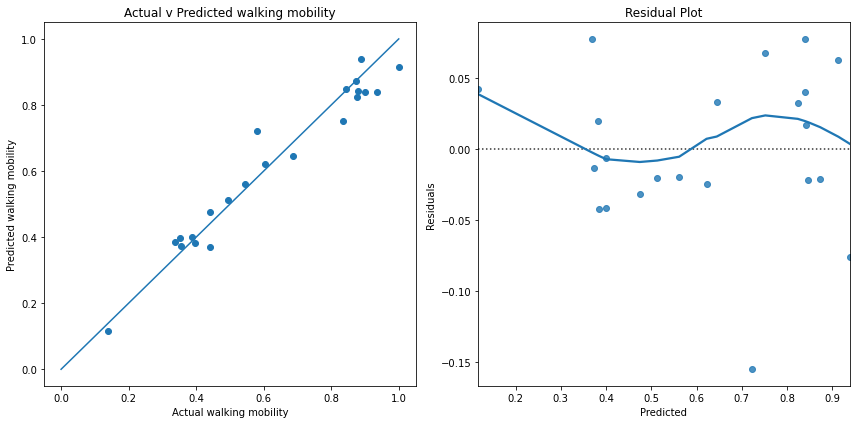

Lag Linear Regression (walking): MSE: 0.0031, RMSE: 0.0558, R-squared: 0.9486


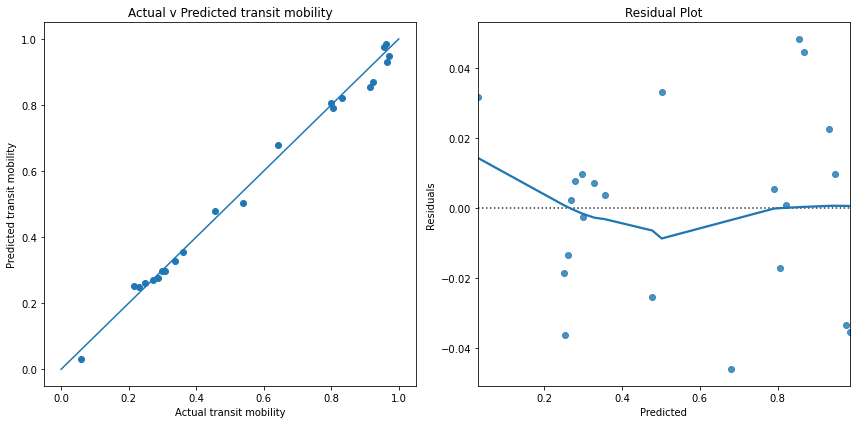

Lag Linear Regression (transit): MSE: 0.0007, RMSE: 0.0268, R-squared: 0.9924


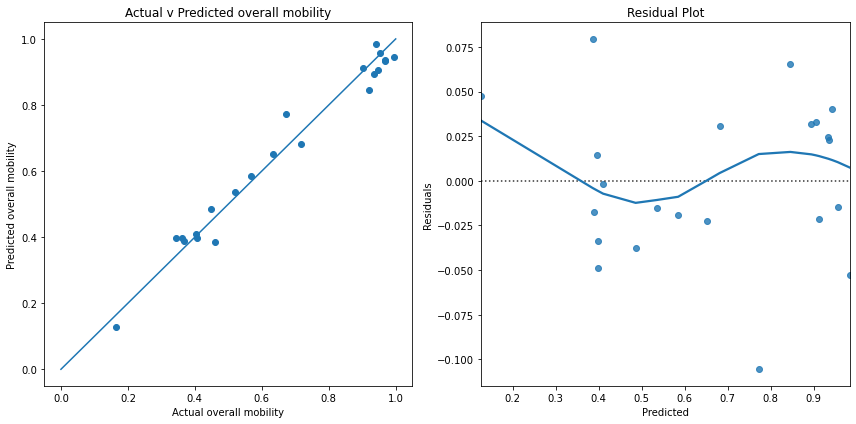

Lag Linear Regression (overall): MSE: 0.0019, RMSE: 0.0432, R-squared: 0.9730


In [23]:
for prediction in ['walking', 'transit', 'overall']:
    _model, (mse, rmse, r2, _) = pipeline(LinearRegression(), lag1, ['weekday', 'month', 'year', 'driving_lag1', 'transit_lag1', 'walking_lag1', 'overall_lag1'], prediction)
    print(f'Lag Linear Regression ({prediction}): MSE: {mse:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}')

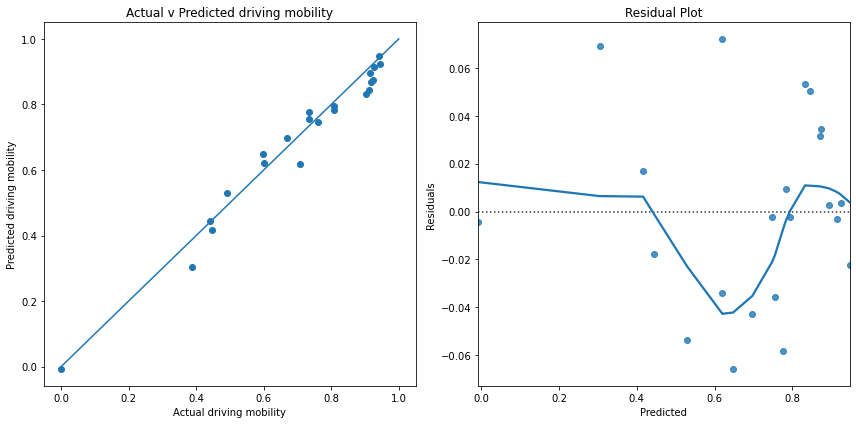

Lag Linear Regression (driving): MSE: 0.0018, RMSE: 0.0421, R-squared: 0.9678


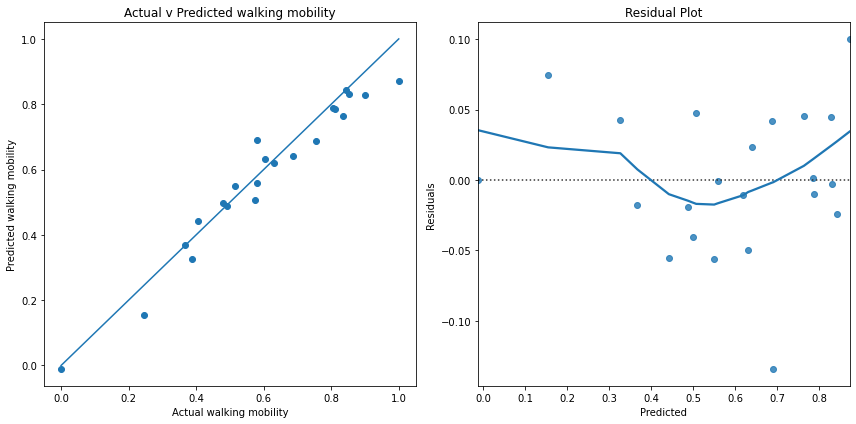

Lag Linear Regression (walking): MSE: 0.0031, RMSE: 0.0552, R-squared: 0.9443


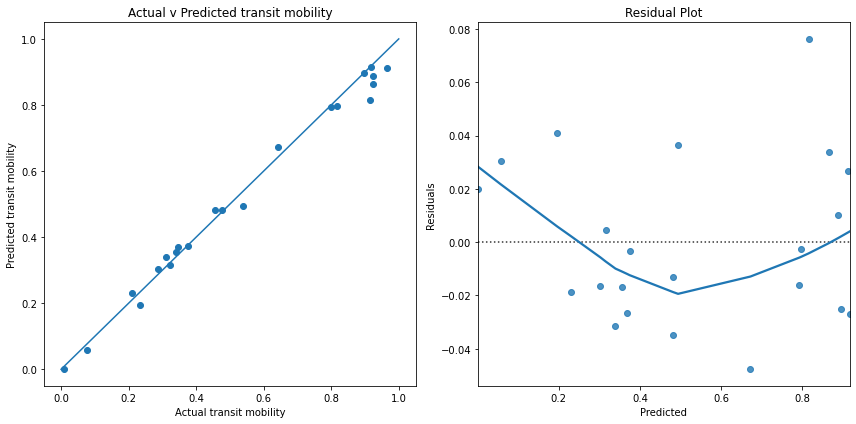

Lag Linear Regression (transit): MSE: 0.0012, RMSE: 0.0344, R-squared: 0.9871


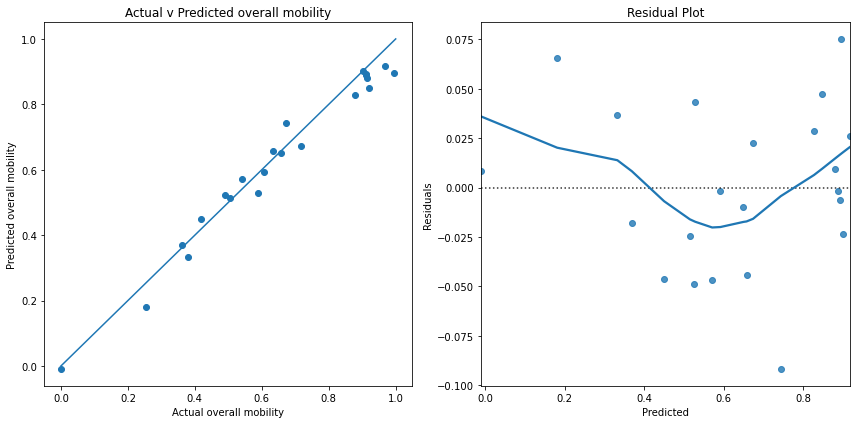

Lag Linear Regression (overall): MSE: 0.0020, RMSE: 0.0448, R-squared: 0.9700


In [24]:
lag2 = lag1.copy()
lag2['driving_lag2'] = lag1['driving_lag1'].shift(1)
lag2['transit_lag2'] = lag1['transit_lag1'].shift(1)
lag2['walking_lag2'] = lag1['walking_lag1'].shift(1)
lag2['overall_lag2'] = lag1['overall_lag1'].shift(1)

lag2 = lag2.dropna()

for prediction in ['driving', 'walking', 'transit', 'overall']:
    lag2_model, (mse, rmse, r2, _) = pipeline(LinearRegression(), lag2, ['weekday', 'month', 'year', 'driving_lag1', 'transit_lag1', 'walking_lag1', 'overall_lag1', 'driving_lag2', 'transit_lag2', 'walking_lag2', 'overall_lag2'], prediction)
    print(f'Lag Linear Regression ({prediction}): MSE: {mse:.4f}, RMSE: {rmse:.4f}, R-squared: {r2:.4f}')

##### Lag 2 - Linear Regression
Doesn't seem to improve much upon single week lag regression model. So, we can stick with <b><i>lag1_model</i></b>